In [2]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F 

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

# Helper function

In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch):
        super(SimpleRNN, self).__init__()

        self.batch = batch
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.fc1 = nn.Linear(184832, 500)
        self.fc2 = nn.Linear(500,536) # layer 1 to output
        
    
    def init_hidden(self):
        return torch.randn(1,1, self.hidden_size)
  
    def forward(self, inputs, hidden):
        in2 = F.relu(self.fc1(inputs))
        outputs, hidden = self.rnn(in2.unsqueeze(1), hidden)
        outputs = F.relu(self.fc2(outputs))
        outputs = outputs.view(outputs.size(0),-1)
        return outputs, hidden

In [4]:
batch_size = 50

In [5]:
model = SimpleRNN(input_size = 184832,
                 hidden_size = 500,
                 output_size = 536,
                 batch = batch_size)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

# Load trained parameters

In [6]:
# load training data 
out_temp = np.load('RNN_data.npy')
inp_temp = np.load('inp.npy')


In [7]:
# Normalize data across the neurons
out = np.zeros(out_temp.shape)
scaler = preprocessing.StandardScaler()
for n in np.arange(536):
    slic = out_temp[n, :, :]
    a = scaler.fit_transform(slic)
    out[n, :,:] = a

In [8]:
# Bin movie data
inp = np.zeros((300, inp_temp.shape[1]))
for i in np.arange(0,900,3):
    msum = (inp_temp[i, :] + inp_temp[i+1, :] + inp_temp[i+2, :]) / 3
    inp[int(i / 3), :] = msum

In [9]:
def get_train_batch(batch_size, dataset_size=300):
    id_list = np.random.choice(np.arange(300), batch_size)
    id_list2 = np.random.choice(np.arange(40), batch_size)
    
    k = 0
    
    inputs_list = []
    outputs_list = []
    for i in id_list:
        j = id_list2[k]
        inputs_list.append(inp[i][:].astype(np.float32))
        outputs_list.append(out[:,j,i].astype(np.float32))
    inputs_list = np.asarray(inputs_list)
    outputs_list = np.asarray(outputs_list)
    return inputs_list, outputs_list 

In [10]:
print(out.shape)
print(inp.shape)

(536, 60, 300)
(300, 184832)


In [11]:
num_samples = 4

In [13]:
#def train_with_epoch(inp, out):
"""
  Train the model and save checkpoints during training.
  
  Args: 
    model: the model to train on
    num_epoch: the number of epochs to train. 
    inputs_seq: the input sequence 
    targets_seq: the target sequence 
    print_epoch: number of epoch interval to print loss. 
    save_epoch: number of epoch interval to save the model.
"""
loss_list = []
switch_accuracy_list = []
total_accuracy_list = []

epoch = 0 
switch_accuracy = 0
total_accuracy = 0
print_epoch = 5
max_epochs = 250


while (epoch < max_epochs):

    epoch += 1 

    model.train()

    total_loss = 0.0 

    for i in range(num_samples):

        # Prepare inputs and targets
        inputs_list, outputs_list = get_train_batch(batch_size=50)

        inputs = Variable(torch.from_numpy(inputs_list))
        labels = Variable(torch.from_numpy(outputs_list), requires_grad=False)

        # Zero out gradients
        optimizer.zero_grad()

        # clear out hidden
        hidden = model.init_hidden()
        hidden = Variable(hidden)

        # forward 
        outputs, hidden = model(inputs, hidden)

        # loss and backward 
        loss = loss_fn(outputs, labels)
        loss.backward()

        # optim
        optimizer.step()

        # record loss
        total_loss += loss.data

    loss_list.append(total_loss)
    if epoch % print_epoch == 0: 
        print("Current epoch: ", epoch, "; total loss is: ", total_loss)

Current epoch:  5 ; total loss is:  tensor(3.0122)
Current epoch:  10 ; total loss is:  tensor(3.0519)
Current epoch:  15 ; total loss is:  tensor(3.0342)
Current epoch:  20 ; total loss is:  tensor(2.9455)
Current epoch:  25 ; total loss is:  tensor(2.9669)
Current epoch:  30 ; total loss is:  tensor(2.9516)
Current epoch:  35 ; total loss is:  tensor(2.9640)
Current epoch:  40 ; total loss is:  tensor(2.9399)
Current epoch:  45 ; total loss is:  tensor(2.9179)
Current epoch:  50 ; total loss is:  tensor(2.9109)
Current epoch:  55 ; total loss is:  tensor(2.9027)
Current epoch:  60 ; total loss is:  tensor(2.8816)
Current epoch:  65 ; total loss is:  tensor(2.8892)
Current epoch:  70 ; total loss is:  tensor(2.8678)
Current epoch:  75 ; total loss is:  tensor(2.8546)
Current epoch:  80 ; total loss is:  tensor(2.8501)
Current epoch:  85 ; total loss is:  tensor(2.8511)
Current epoch:  90 ; total loss is:  tensor(2.8424)
Current epoch:  95 ; total loss is:  tensor(2.8312)
Current epoch

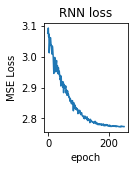

In [17]:
plt.figure(figsize=(1.5,2))
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.title('RNN loss')
plt.savefig('loss2.png', bbox_inches="tight")

In [49]:
out_test = out[:, 55, 9].astype(np.float32)
inp_test = np.reshape(inp[9, :].astype(np.float32), (1, 184832))

inputs = Variable(torch.from_numpy(inp_test), requires_grad=False)

hidden = model.init_hidden()
hidden = Variable(hidden)

output_test, hidden = model(inputs, hidden)

#output_test = F.sigmoid(output_test)
#pred = (output.data >= 0.5).long()



In [50]:
inp_test.shape

(1, 184832)

In [51]:
output_test.data

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1658, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0648, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

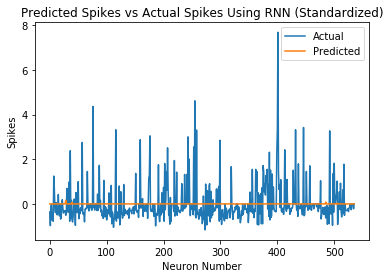

In [61]:
a = output_test.data.numpy()
plt.plot(out_test)
plt.plot(a.flatten())
plt.ylabel('Spikes')
plt.xlabel('Neuron Number')
plt.legend(['Actual', 'Predicted'])
plt.title('Predicted Spikes vs Actual Spikes Using RNN (Standardized)')
plt.savefig('predicted2.png')
plt.show()

In [56]:
np.save('a.npy',a)